In [1]:
import openmc_fusion_benchmarks as ofb
import matplotlib.pyplot as plt
import numpy as np

import helpers

In [2]:
# read sinbad data
experiment_file = ofb.ResultsFromDatabase('experiment.h5', path='results_database')

In [3]:
# read openmc results in results_database/
openmc_fendl3_file = ofb.ResultsFromDatabase('openmc-0-14-0_fendl32b.h5', path='results_database')

In [4]:
# initialize reaction rate plots
reaction_labels = ['$^{93}$Nb(n,2n)$^{92m}$Nb', '$^{27}$Al(n,\u03B1)$^{24}$Na', 
                   '$^{115}$In(n,n\')$^{115m}$In', '$^{197}$Au(n,\u03B3)$^{198}$Au', 
                   '$^{186}$W(n,\u03B3)$^{187}$W']

ylabel = r'Reaction Rate $(\frac{1}{src \cdot atom})$'

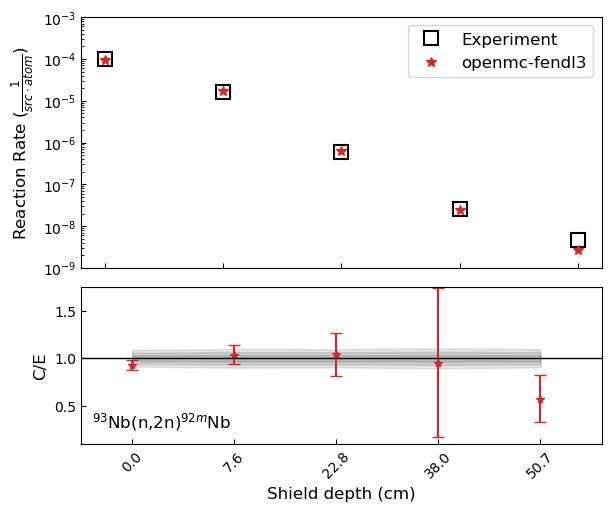

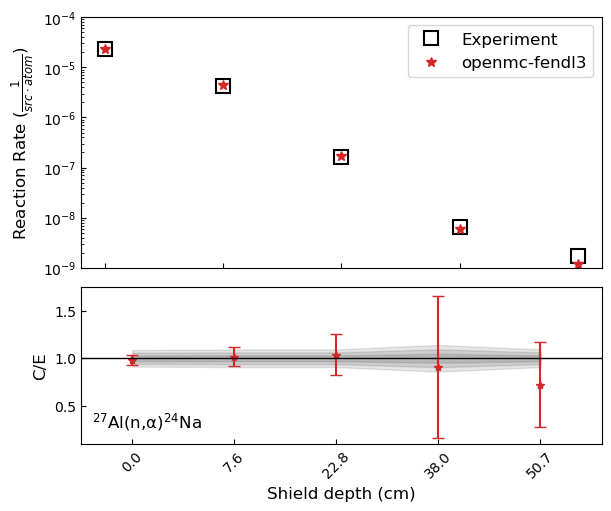

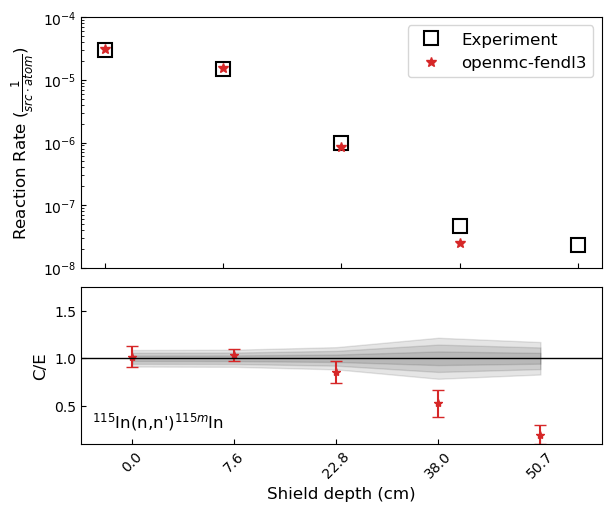

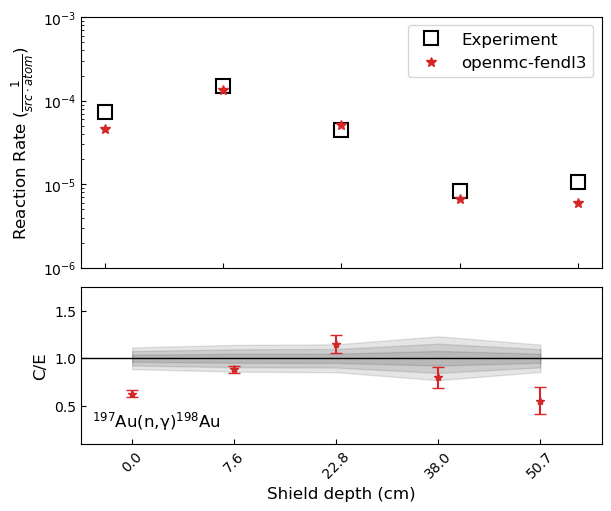

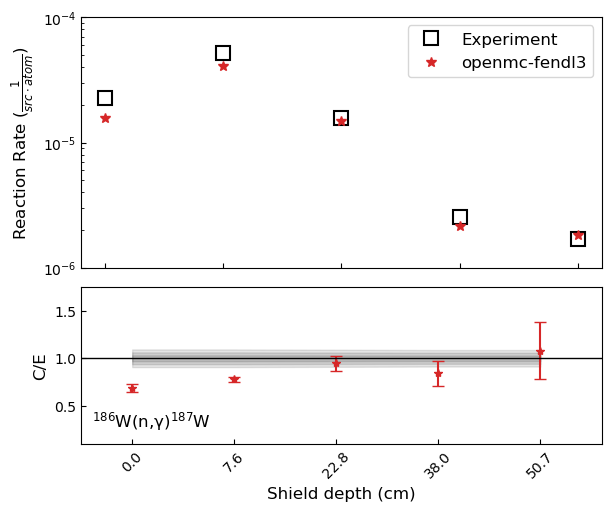

In [5]:
for i,foil in enumerate(helpers.foil_list):

    # extract tallies
    measured = experiment_file.get_tally_dataframe(f'rr_{foil}')
    
    # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'rr_{foil}')
    # openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'rr_{foil}')
    
    # plot
    # preprocessing
    dtype_label = reaction_labels[i]
    tickers = np.arange(len(measured))
    xaxis = experiment_file.get_tally_xaxis(f'rr_{foil}')
    means = [measured['mean']]

    # generate figure
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

    # plot results
    ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')

    # # openmc results
    ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', alpha=1, label='openmc-fendl3')
    # ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

    ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    
    # openmc results
    ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'],
                marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', alpha=1, label='_label')
    # ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
    #             marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

    # adjust
    ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
    ax1.set_yscale('log')
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.set_xticks(tickers)
    ax1.tick_params(axis='x', labelbottom=False)
    ax1.tick_params(axis='both', which='both', direction='in')
    ax1.legend(fontsize=12)
    #
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
                linewidth=1, label='_nolegend_')
    ax2.set_xlim([-0.5, tickers[-1] + .6])
    ax2.set_ylim([0.1, 1.75])
    ax2.set_xticks(tickers)
    ax2.set_xticklabels(measured[xaxis])
    ax2.tick_params(axis='x', labelrotation=45)
    ax2.tick_params(axis='both', which='both', direction='in')
    ax2.set_xlabel(xaxis, fontsize=12)
    ax2.set_ylabel('C/E', fontsize=12)
    ax2.annotate(dtype_label, [0.02, 0.07], xycoords='axes fraction',
                        horizontalalignment='left', verticalalignment='bottom', fontsize=12)

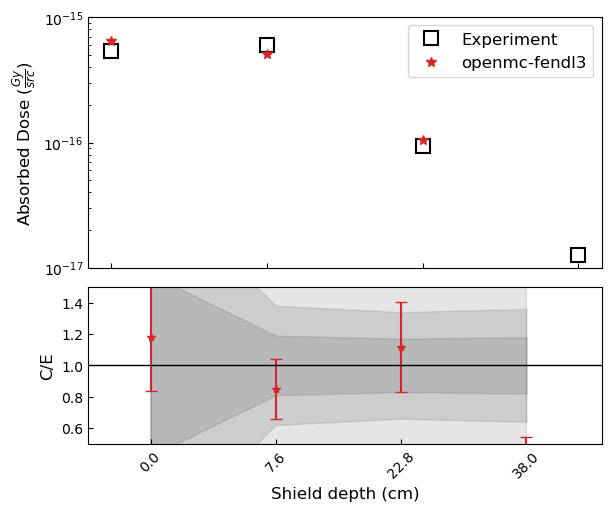

In [6]:
ylabel = r'Absorbed Dose $(\frac{Gy}{src})$'
# extract tallies
measured = experiment_file.get_tally_dataframe('nuclear_heating')

# # openmc from results_database
openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe('nuclear_heating')
# openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe('nuclear_heating')

# plot
# preprocessing
dtype_label = reaction_labels[i]
tickers = np.arange(len(measured))
xaxis = experiment_file.get_tally_xaxis('nuclear_heating')
means = [measured['mean']]

# generate figure
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), gridspec_kw={'height_ratios': [2, 1.25]}, constrained_layout=True)

# plot results
ax1.plot(tickers, measured['mean'], marker='s', ms=10, ls='none', mew=1.5, mec='k', mfc='none', label='Experiment')

# openmc results
ax1.plot(tickers, openmc_fendl3['mean'], marker='*', ms=7, ls='none', color='tab:red', alpha=1, label='openmc-fendl3')
# ax1.plot(tickers, openmc_fendl3['mean'], marker='.', ms=7, ls='none', color='tab:purple', label='openmc-endfb8')

ofb.plot_stddev_area(ax=ax2, ticks=tickers, mean=np.ones(len(measured['mean'])), std_dev=measured['std. dev.']/measured['mean'])
    
# openmc results
ax2.errorbar(tickers, openmc_fendl3['mean']/measured['mean'], openmc_fendl3['std. dev.']/measured['mean'], 
        marker='*', ms=6, capsize=4, barsabove=True, color='tab:red', ls='none', alpha=1, label='_label')
# ax2.errorbar(tickers, openmc_endfb8['mean']/measured['mean'], openmc_endfb8['std. dev.']/measured['mean'], 
#                 marker='.', ms=6, capsize=4, barsabove=True, color='tab:purple', ls='none', label='_label')

# adjust
ofb.add_floor_ceiling(ax=ax1, values=means, scale='log', gap=0.)
ax1.set_yscale('log')
ax1.set_ylabel(ylabel, fontsize=12)
ax1.set_xticks(tickers)
ax1.tick_params(axis='x', labelbottom=False)
ax1.tick_params(axis='both', which='both', direction='in')
ax1.legend(fontsize=12)
#
ax2.hlines(1.0, -1, 20, colors='k', linestyles='-',
            linewidth=1, label='_nolegend_')
ax2.set_xlim([-0.5, tickers[-1] + .6])
ax2.set_ylim([0.5, 1.5])
ax2.set_xticks(tickers)
ax2.set_xticklabels(measured[xaxis])
ax2.tick_params(axis='x', labelrotation=45)
ax2.tick_params(axis='both', which='both', direction='in')
ax2.set_xlabel(xaxis, fontsize=12)
ax2.set_ylabel('C/E', fontsize=12)

plt.show()

In [7]:
# initialize spectra data
ylabel = r'Neutron flux $(\frac{n}{cm^2 \cdot src \cdot lethargy})$'

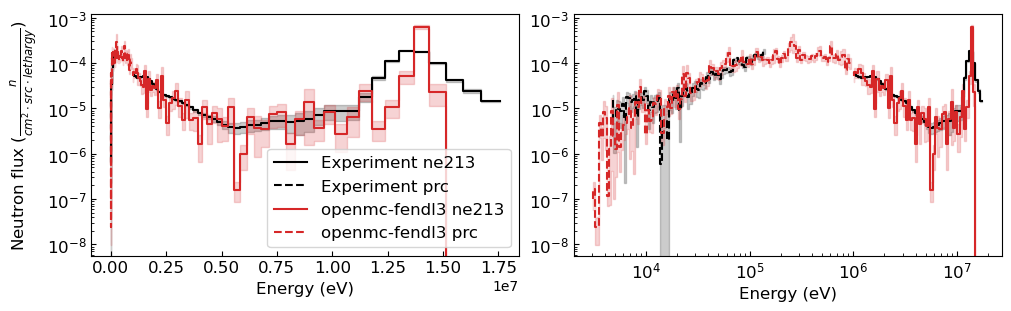

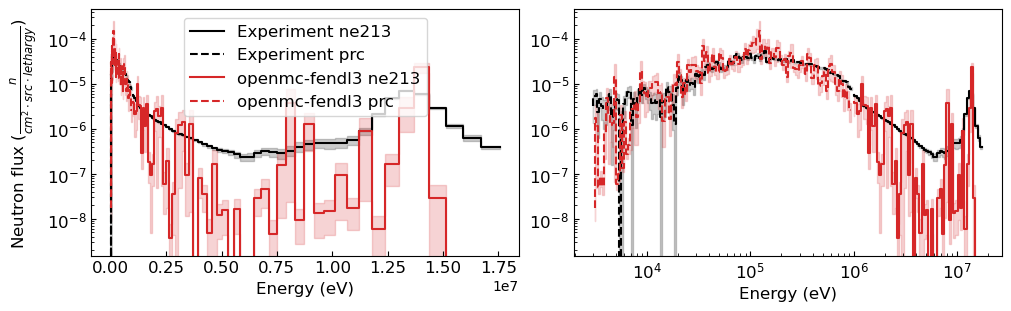

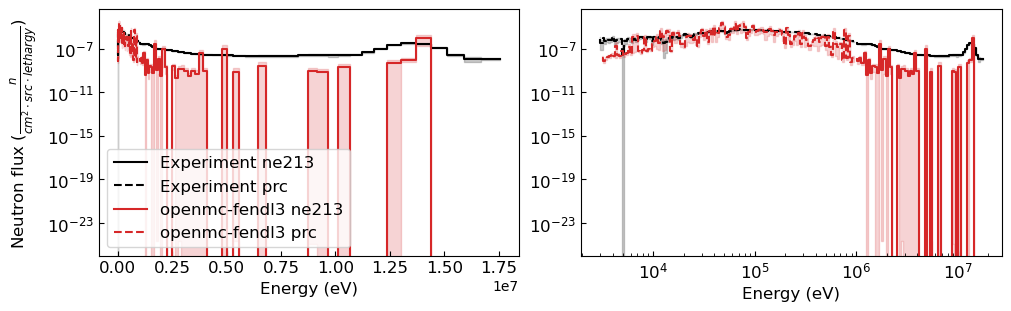

In [8]:
for i, d in enumerate(helpers.detector_list):
    # extract tallies
    ne213 = experiment_file.get_tally_dataframe(f'nspectrum_ne213_{d}')
    prc = experiment_file.get_tally_dataframe(f'nspectrum_prc_{d}')
    
    # openmc from results_database/
    openmc_fendl3_ne213 = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_ne213_{d}')
    openmc_fendl3_prc = openmc_fendl3_file.get_tally_dataframe(f'nspectrum_prc_{d}')
    # openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'nspectrum_{d}')

    # plot
    # preprocessing
    ne213_mean = ne213['mean'] / np.log(ne213['energy high [eV]']/ne213['energy low [eV]'])
    ne213_stddev = ne213['std. dev.'] / np.log(ne213['energy high [eV]']/ne213['energy low [eV]'])
    prc_mean = prc['mean'] / np.log(prc['energy high [eV]']/prc['energy low [eV]'])
    prc_stddev = prc['std. dev.'] / np.log(prc['energy high [eV]']/prc['energy low [eV]'])

    openmc_fendl3_ne213_mean = openmc_fendl3_ne213['mean'] / np.log(openmc_fendl3_ne213['energy high [eV]']/openmc_fendl3_ne213['energy low [eV]'])
    openmc_fendl3_ne213_stddev = openmc_fendl3_ne213['std. dev.'] / np.log(openmc_fendl3_ne213['energy high [eV]']/openmc_fendl3_ne213['energy low [eV]'])
    openmc_fendl3_prc_mean = openmc_fendl3_prc['mean'] / np.log(openmc_fendl3_prc['energy high [eV]']/openmc_fendl3_prc['energy low [eV]'])
    openmc_fendl3_prc_stddev = openmc_fendl3_prc['std. dev.'] / np.log(openmc_fendl3_prc['energy high [eV]']/openmc_fendl3_prc['energy low [eV]'])
    # openmc_endfb8_mean = openmc_endfb8['mean'] / np.log(openmc_endfb8['energy high [eV]']/openmc_endfb8['energy low [eV]'])
    # openmc_endfb8_stddev = openmc_endfb8['std. dev.'] / np.log(openmc_endfb8['energy high [eV]']/openmc_endfb8['energy low [eV]'])
    
    # generate figure
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 3), constrained_layout=True)

    for ax in (ax1,ax2):
        # plot results
        ax.step(ne213['energy low [eV]'], ne213_mean, lw=1.5, c='k', label='Experiment ne213')
        ax.fill_between(ne213['energy low [eV]'], ne213_mean - ne213_stddev, ne213_mean +
                                ne213_stddev, step='pre', color='k', alpha=0.2)
        ax.step(prc['energy low [eV]'], prc_mean, lw=1.5, ls='--', c='k', label='Experiment prc')
        ax.fill_between(prc['energy low [eV]'], prc_mean - prc_stddev, prc_mean +
                                prc_stddev, step='pre', color='k', alpha=0.2)
    
        # openmc results
        ax.step(openmc_fendl3_ne213['energy low [eV]'], openmc_fendl3_ne213_mean, lw=1.5, c='tab:red', label='openmc-fendl3 ne213')
        ax.fill_between(openmc_fendl3_ne213['energy low [eV]'], openmc_fendl3_ne213_mean - openmc_fendl3_ne213_stddev, 
                        openmc_fendl3_ne213_mean + openmc_fendl3_ne213_stddev, step='pre', color='tab:red', alpha=0.2)
        ax.step(openmc_fendl3_prc['energy low [eV]'], openmc_fendl3_prc_mean, lw=1.5, ls='--', c='tab:red', label='openmc-fendl3 prc')
        ax.fill_between(openmc_fendl3_prc['energy low [eV]'], openmc_fendl3_prc_mean - openmc_fendl3_prc_stddev, 
                        openmc_fendl3_prc_mean + openmc_fendl3_prc_stddev, step='pre', color='tab:red', alpha=0.2)

        # adjust
        ax.set_yscale('log')
        ax.set_xlabel('Energy (eV)', fontsize=12)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)

    # adjust
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.legend(fontsize=12)
    ax2.set_xscale('log')

In [9]:
# initialize spectra data
detector_position = ['76', '228', '380']
ylabel = r'Gamma flux $(\frac{p}{cm^2 \cdot src \cdot lethargy})$'

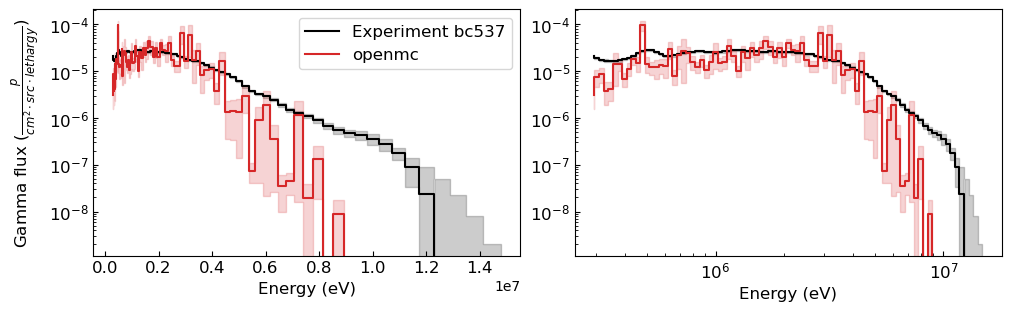

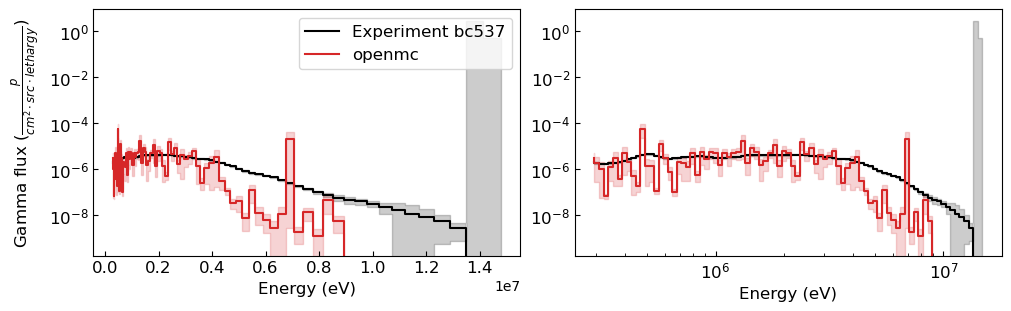

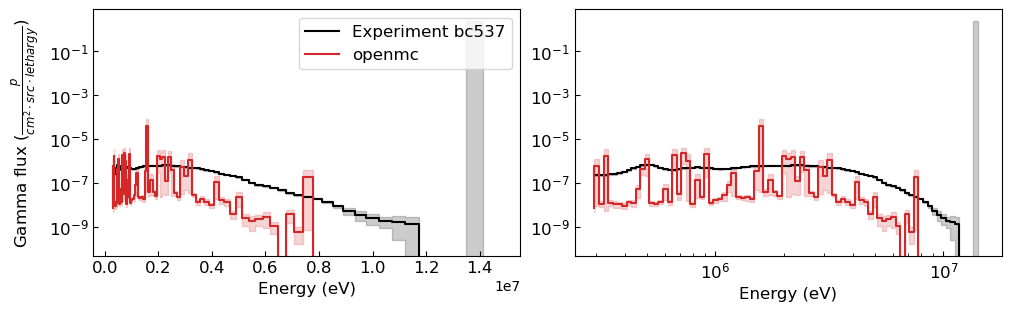

In [10]:
for i, d in enumerate(helpers.detector_list):
    # extract tallies
    bc537 = experiment_file.get_tally_dataframe(f'gspectrum_bc537_{d}')
    
    # # openmc from results_database/
    openmc_fendl3 = openmc_fendl3_file.get_tally_dataframe(f'gspectrum_bc537_{d}')
    # openmc_endfb8 = openmc_endfb8_file.get_tally_dataframe(f'nspectrum_{d}')

    # plot
    # preprocessing
    bc537_mean = bc537['mean'] / np.log(bc537['energy high [eV]']/bc537['energy low [eV]'])
    bc537_stddev = bc537['std. dev.'] / np.log(bc537['energy high [eV]']/bc537['energy low [eV]'])

    openmc_fendl3_mean = openmc_fendl3['mean'] / np.log(openmc_fendl3['energy high [eV]']/openmc_fendl3['energy low [eV]'])
    openmc_fendl3_stddev = openmc_fendl3['std. dev.'] / np.log(openmc_fendl3['energy high [eV]']/openmc_fendl3['energy low [eV]'])
    # openmc_endfb8_mean = openmc_endfb8['mean'] / np.log(openmc_endfb8['energy high [eV]']/openmc_endfb8['energy low [eV]'])
    # openmc_endfb8_stddev = openmc_endfb8['std. dev.'] / np.log(openmc_endfb8['energy high [eV]']/openmc_endfb8['energy low [eV]'])
    
    # generate figure
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10, 3), constrained_layout=True)

    for ax in (ax1,ax2):
        # plot results
        ax.step(bc537['energy low [eV]'], bc537_mean, lw=1.5, c='k', label='Experiment bc537')
        ax.fill_between(bc537['energy low [eV]'], bc537_mean - bc537_stddev, bc537_mean +
                                bc537_stddev, step='pre', color='k', alpha=0.2)
    
        # openmc results
        ax.step(openmc_fendl3['energy low [eV]'], openmc_fendl3_mean, lw=1.5, c='tab:red', label='openmc')
        ax.fill_between(openmc_fendl3['energy low [eV]'], openmc_fendl3_mean - openmc_fendl3_stddev, openmc_fendl3_mean +
                                openmc_fendl3_stddev, step='pre', color='tab:red', alpha=0.2)

        # adjust
        ax.set_yscale('log')
        ax.set_xlabel('Energy (eV)', fontsize=12)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)

    # adjust
    ax1.set_ylabel(ylabel, fontsize=12)
    ax1.legend(fontsize=12)
    ax2.set_xscale('log')